In [1]:
from glob import glob
from os.path import join
import pandas as pd

In [2]:
import numpy as np
import pickle

def load_pickle_safely(pickle_file):
    with open(pickle_file, 'rb') as f:
        return pickle.load(f)

def maybe_load_pickle(pickle_file):
    try:
        result = load_pickle_safely(pickle_file)
    except Exception:
        return None

def compute_means(draw_dict):
    
    return {x: y.mean(axis=(0, 1)) for x, y in draw_dict.items()}

def compute_sds(draw_dict):
    
    return {x: y.std(axis=(0, 1)) for x, y in draw_dict.items()}

def compute_z_score_mean(mean_dict, ref_mean_dict, ref_sd_dict):
    
    return {x: (mean_dict[x] - ref_mean_dict[x]) / ref_sd_dict[x] for x in mean_dict}

def compute_relative_error_sd(sd_dict, ref_sd_dict):

    return {x: (sd_dict[x] - ref_sd_dict[x]) / ref_sd_dict[x] for x in ref_sd_dict}

def flatten_dict(var_dict, names):

    return np.concatenate([var_dict[x].reshape(-1) for x in names])


In [14]:
from os.path import split, splitext

def load_moment_df(draw_folder):

    model_dicts = glob(join(draw_folder, "draw_dicts", "*.npz"))
    data = pd.DataFrame({"draw_dict_path": model_dicts})

    data["draws"] = data["draw_dict_path"].apply(lambda x: dict(np.load(x)))
    data["means"] = data["draws"].apply(compute_means)
    data["sds"] = data["draws"].apply(compute_sds)

    # No need for the draws any more for now
    data = data.drop(columns="draws")

    # Fetch model name
    data['model_name'] = data['draw_dict_path'].apply(lambda x: splitext(split(x)[-1])[0])

    return data

def check_convergence_sadvi(metadata, max_iter=100000):

    return metadata['steps'] < max_iter


def check_convergence_raabbvi(metadata, max_iter=19900):

    n_steps = metadata['kl_hist_i'].max()

    return n_steps < max_iter


def add_metadata(moment_df, method):

    assert method in ['NUTS', 'RAABBVI', 'DADVI', 'LRVB', 'SADVI', 'SADVI-FR']

    if method in ['RAABBVI', 'DADVI', 'LRVB', 'SADVI', 'SADVI-FR']:
        subdir_lookup = {
            'RAABBVI': 'info',
            'DADVI': 'dadvi_info',
            'LRVB': 'lrvb_info',
            'SADVI': 'info',
            'SADVI-FR': 'info'
        }
        subdir = subdir_lookup[method]
        moment_df["info_path"] = (
            moment_df["draw_dict_path"]
            .str.replace("draw_dicts", subdir)
            .str.replace(".npz", ".pkl", regex=False)
        )

        moment_df['metadata'] = moment_df['info_path'].apply(load_pickle_safely)
        moment_df['runtime'] = moment_df['metadata'].apply(lambda x: x['runtime'])

        if method.startswith('SADVI'):
            moment_df['converged'] = moment_df['metadata'].apply(check_convergence_sadvi)
        elif method == 'RAABBVI':
            moment_df['converged'] = moment_df['metadata'].apply(check_convergence_raabbvi)

    else:
        # It's NUTS; get runtime:
        moment_df['runtime_path'] = (
            moment_df['draw_dict_path']
            .str.replace('draw_dicts', 'runtimes')
            .str.replace('.npz', '.csv', regex=False)
        )
        moment_df['runtime'] = (
            moment_df['runtime_path']
            .apply(lambda x: pd.read_csv(x)['0'].iloc[0])
        )

        # TODO: get rhat

    return moment_df

from os.path import join

base_folder = '../blade_runs/'

folder_method_list = (
    (join(base_folder, "nuts_results/"), 'NUTS'),
    (join(base_folder, "dadvi_results/"), 'DADVI'),
    (join(base_folder, "lrvb_results/"), 'LRVB'),
    (join(base_folder, "raabbvi_results/"), 'RAABBVI'),
    (join(base_folder, "sadvi_results/"), 'SADVI'),
    (join(base_folder, "sfullrank_advi_results/"), 'SADVI-FR')
)

all_results = dict()

for cur_folder, cur_method in folder_method_list:

    print(cur_method, cur_folder)

    data = load_moment_df(cur_folder)

    data = add_metadata(data, cur_method)

    all_results[cur_method] = data


NUTS ../blade_runs/nuts_results/
DADVI ../blade_runs/dadvi_results/
../blade_runs/dadvi_results/dadvi_info/radon_group.pkl
../blade_runs/dadvi_results/dadvi_info/occ_det.pkl
../blade_runs/dadvi_results/dadvi_info/wells_interaction.pkl
../blade_runs/dadvi_results/dadvi_info/logearn_height.pkl
../blade_runs/dadvi_results/dadvi_info/wells_dae_c.pkl
../blade_runs/dadvi_results/dadvi_info/sesame_one_pred_b.pkl
../blade_runs/dadvi_results/dadvi_info/test_rstanarm.pkl
../blade_runs/dadvi_results/dadvi_info/mesquite_va.pkl
../blade_runs/dadvi_results/dadvi_info/radon_intercept.pkl
../blade_runs/dadvi_results/dadvi_info/wells_daae_c.pkl
../blade_runs/dadvi_results/dadvi_info/sesame_one_pred_a.pkl
../blade_runs/dadvi_results/dadvi_info/earn_height.pkl
../blade_runs/dadvi_results/dadvi_info/earnings1.pkl
../blade_runs/dadvi_results/dadvi_info/wells_predicted.pkl
../blade_runs/dadvi_results/dadvi_info/mesquite_log.pkl
../blade_runs/dadvi_results/dadvi_info/mesquite_volume.pkl
../blade_runs/dadvi_r

../blade_runs/raabbvi_results/info/wells_d100ars.pkl
../blade_runs/raabbvi_results/info/microcredit.pkl
../blade_runs/raabbvi_results/info/wells_interaction_c.pkl
../blade_runs/raabbvi_results/info/kidscore_momiq.pkl
../blade_runs/raabbvi_results/info/sesame_multi_preds_3a.pkl
../blade_runs/raabbvi_results/info/kidiq_interaction.pkl
../blade_runs/raabbvi_results/info/nes2000_vote.pkl
../blade_runs/raabbvi_results/info/logearn_height_male.pkl
../blade_runs/raabbvi_results/info/logearn_logheight.pkl
../blade_runs/raabbvi_results/info/wells_dae_inter_c.pkl
../blade_runs/raabbvi_results/info/wells_dae.pkl
../blade_runs/raabbvi_results/info/mesquite_vas.pkl
../blade_runs/raabbvi_results/info/earnings_vary_si.pkl
../blade_runs/raabbvi_results/info/radon_vary_si.pkl
../blade_runs/raabbvi_results/info/kidscore_momhs.pkl
../blade_runs/raabbvi_results/info/earnings_latin_square.pkl
../blade_runs/raabbvi_results/info/logearn_interaction.pkl
../blade_runs/raabbvi_results/info/election88.pkl
../bla

In [15]:
def add_deviation_stats(model_df, reference_df):

    together = model_df.merge(
        reference_df, on="model_name", suffixes=("_model", "_reference")
    )

    together["mean_deviations"] = together.apply(
        lambda x: compute_z_score_mean(
            x["means_model"], x["means_reference"], x["sds_reference"]
        ),
        axis=1,
    )

    together["sd_deviations"] = together.apply(
        lambda x: compute_relative_error_sd(x["sds_model"], x["sds_reference"]), axis=1
    )

    together["var_names"] = together["means_reference"].apply(
        lambda x: sorted(list(x.keys()))
    )


    # Add these to the model stats
    cols_to_keep = [
        "model_name",
        "mean_deviations",
        "sd_deviations",
        "var_names",
    ]

    new_stats = together[cols_to_keep]

    return model_df.merge(new_stats, on='model_name', how='left')


def add_derived_stats(model_df):

    model_df["mean_deviations_flat"] = model_df.apply(
        lambda x: flatten_dict(x["mean_deviations"], x["var_names"]), axis=1
    )

    model_df["sd_deviations_flat"] = model_df.apply(
        lambda x: flatten_dict(x["sd_deviations"], x["var_names"]), axis=1
    )

    model_df['mean_rms'] = model_df['mean_deviations_flat'].apply(lambda x: np.sqrt(np.mean(x**2)))
    model_df['sd_rms'] = model_df['sd_deviations_flat'].apply(lambda x: np.sqrt(np.mean(x**2)))

    return model_df


In [16]:
all_results['SADVI']

,draw_dict_path,means,sds,model_name,info_path,metadata,runtime,converged
0,../blade_runs/sadvi_results/draw_dicts/radon_g...,"{'Intercept': 1.2505417197672661, 'x': [-0.658...","{'Intercept': 0.02730806232966237, 'x': [0.071...",radon_group,../blade_runs/sadvi_results/info/radon_group.pkl,"{'steps': 100000, 'runtime': 21.600921630859375}",21.600922,False
1,../blade_runs/sadvi_results/draw_dicts/occ_det...,"{'w_env': [[0.1658606011225259, -0.03987874096...","{'w_env': [[1.0288546120487498, 1.039400766953...",occ_det,../blade_runs/sadvi_results/info/occ_det.pkl,"{'steps': 100000, 'runtime': 1076.2247185707092}",1076.224719,False
2,../blade_runs/sadvi_results/draw_dicts/wells_i...,"{'Intercept': 0.33733751688907193, 'dist100': ...","{'Intercept': 0.0422863915229066, 'dist100': [...",wells_interaction,../blade_runs/sadvi_results/info/wells_interac...,"{'steps': 100000, 'runtime': 29.87992238998413}",29.879922,False
3,../blade_runs/sadvi_results/draw_dicts/logearn...,"{'Intercept': 9.712446301040425, 'height': [0....","{'Intercept': 0.03022450233190752, 'height': [...",logearn_height,../blade_runs/sadvi_results/info/logearn_heigh...,"{'steps': 46199, 'runtime': 5.917670249938965}",5.917670,True
4,../blade_runs/sadvi_results/draw_dicts/wells_d...,"{'Intercept': 0.3399103044706485, 'c_dist100':...","{'Intercept': 0.04255129389429329, 'c_dist100'...",wells_dae_c,../blade_runs/sadvi_results/info/wells_dae_c.pkl,"{'steps': 100000, 'runtime': 31.49224543571472}",31.492245,False
5,../blade_runs/sadvi_results/draw_dicts/sesame_...,"{'Intercept': 26.72985845472546, 'encouraged':...","{'Intercept': 1.0099293284691508, 'encouraged'...",sesame_one_pred_b,../blade_runs/sadvi_results/info/sesame_one_pr...,"{'steps': 36399, 'runtime': 4.864454984664917}",4.864455,True
6,../blade_runs/sadvi_results/draw_dicts/test_rs...,"{'Intercept': -0.7015216744302136, 'x': [2.539...","{'Intercept': 0.003570904044275687, 'x': [0.00...",test_rstanarm,../blade_runs/sadvi_results/info/test_rstanarm...,"{'steps': 100000, 'runtime': 26.469897747039795}",26.469898,False
7,../blade_runs/sadvi_results/draw_dicts/mesquit...,"{'Intercept': 5.9180697304648975, 'np.log(I(di...","{'Intercept': 0.056743846554802094, 'np.log(I(...",mesquite_va,../blade_runs/sadvi_results/info/mesquite_va.pkl,"{'steps': 100000, 'runtime': 11.415233612060547}",11.415234,False
8,../blade_runs/sadvi_results/draw_dicts/radon_i...,"{'Intercept': 1.305624429308612, '1|county_off...","{'Intercept': 0.029535601570931144, '1|county_...",radon_intercept,../blade_runs/sadvi_results/info/radon_interce...,"{'steps': 100000, 'runtime': 13.50944471359253}",13.509445,False
9,../blade_runs/sadvi_results/draw_dicts/wells_d...,"{'Intercept': 0.33708627317667106, 'c_dist100'...","{'Intercept': 0.04353073982945113, 'c_dist100'...",wells_daae_c,../blade_runs/sadvi_results/info/wells_daae_c.pkl,"{'steps': 100000, 'runtime': 31.845603942871094}",31.845604,False


In [24]:
raabbvi_maxiter = 19900

dadvi_with_deviations = add_deviation_stats(all_results['DADVI'], all_results['NUTS']).dropna()
dadvi_with_deviations = add_derived_stats(dadvi_with_deviations)

raabvi_with_deviations = add_deviation_stats(all_results['SADVI'], all_results['NUTS']).dropna()
raabvi_with_deviations = add_derived_stats(raabvi_with_deviations)


In [25]:
all_results['SADVI']['converged'].mean()

0.25862068965517243

In [26]:
comparison = dadvi_with_deviations.merge(raabvi_with_deviations, on='model_name', suffixes=('_lrvb', '_raabbvi'))

In [27]:
raabvi_with_deviations.iloc[0]['metadata'].keys()

dict_keys(['steps', 'runtime'])

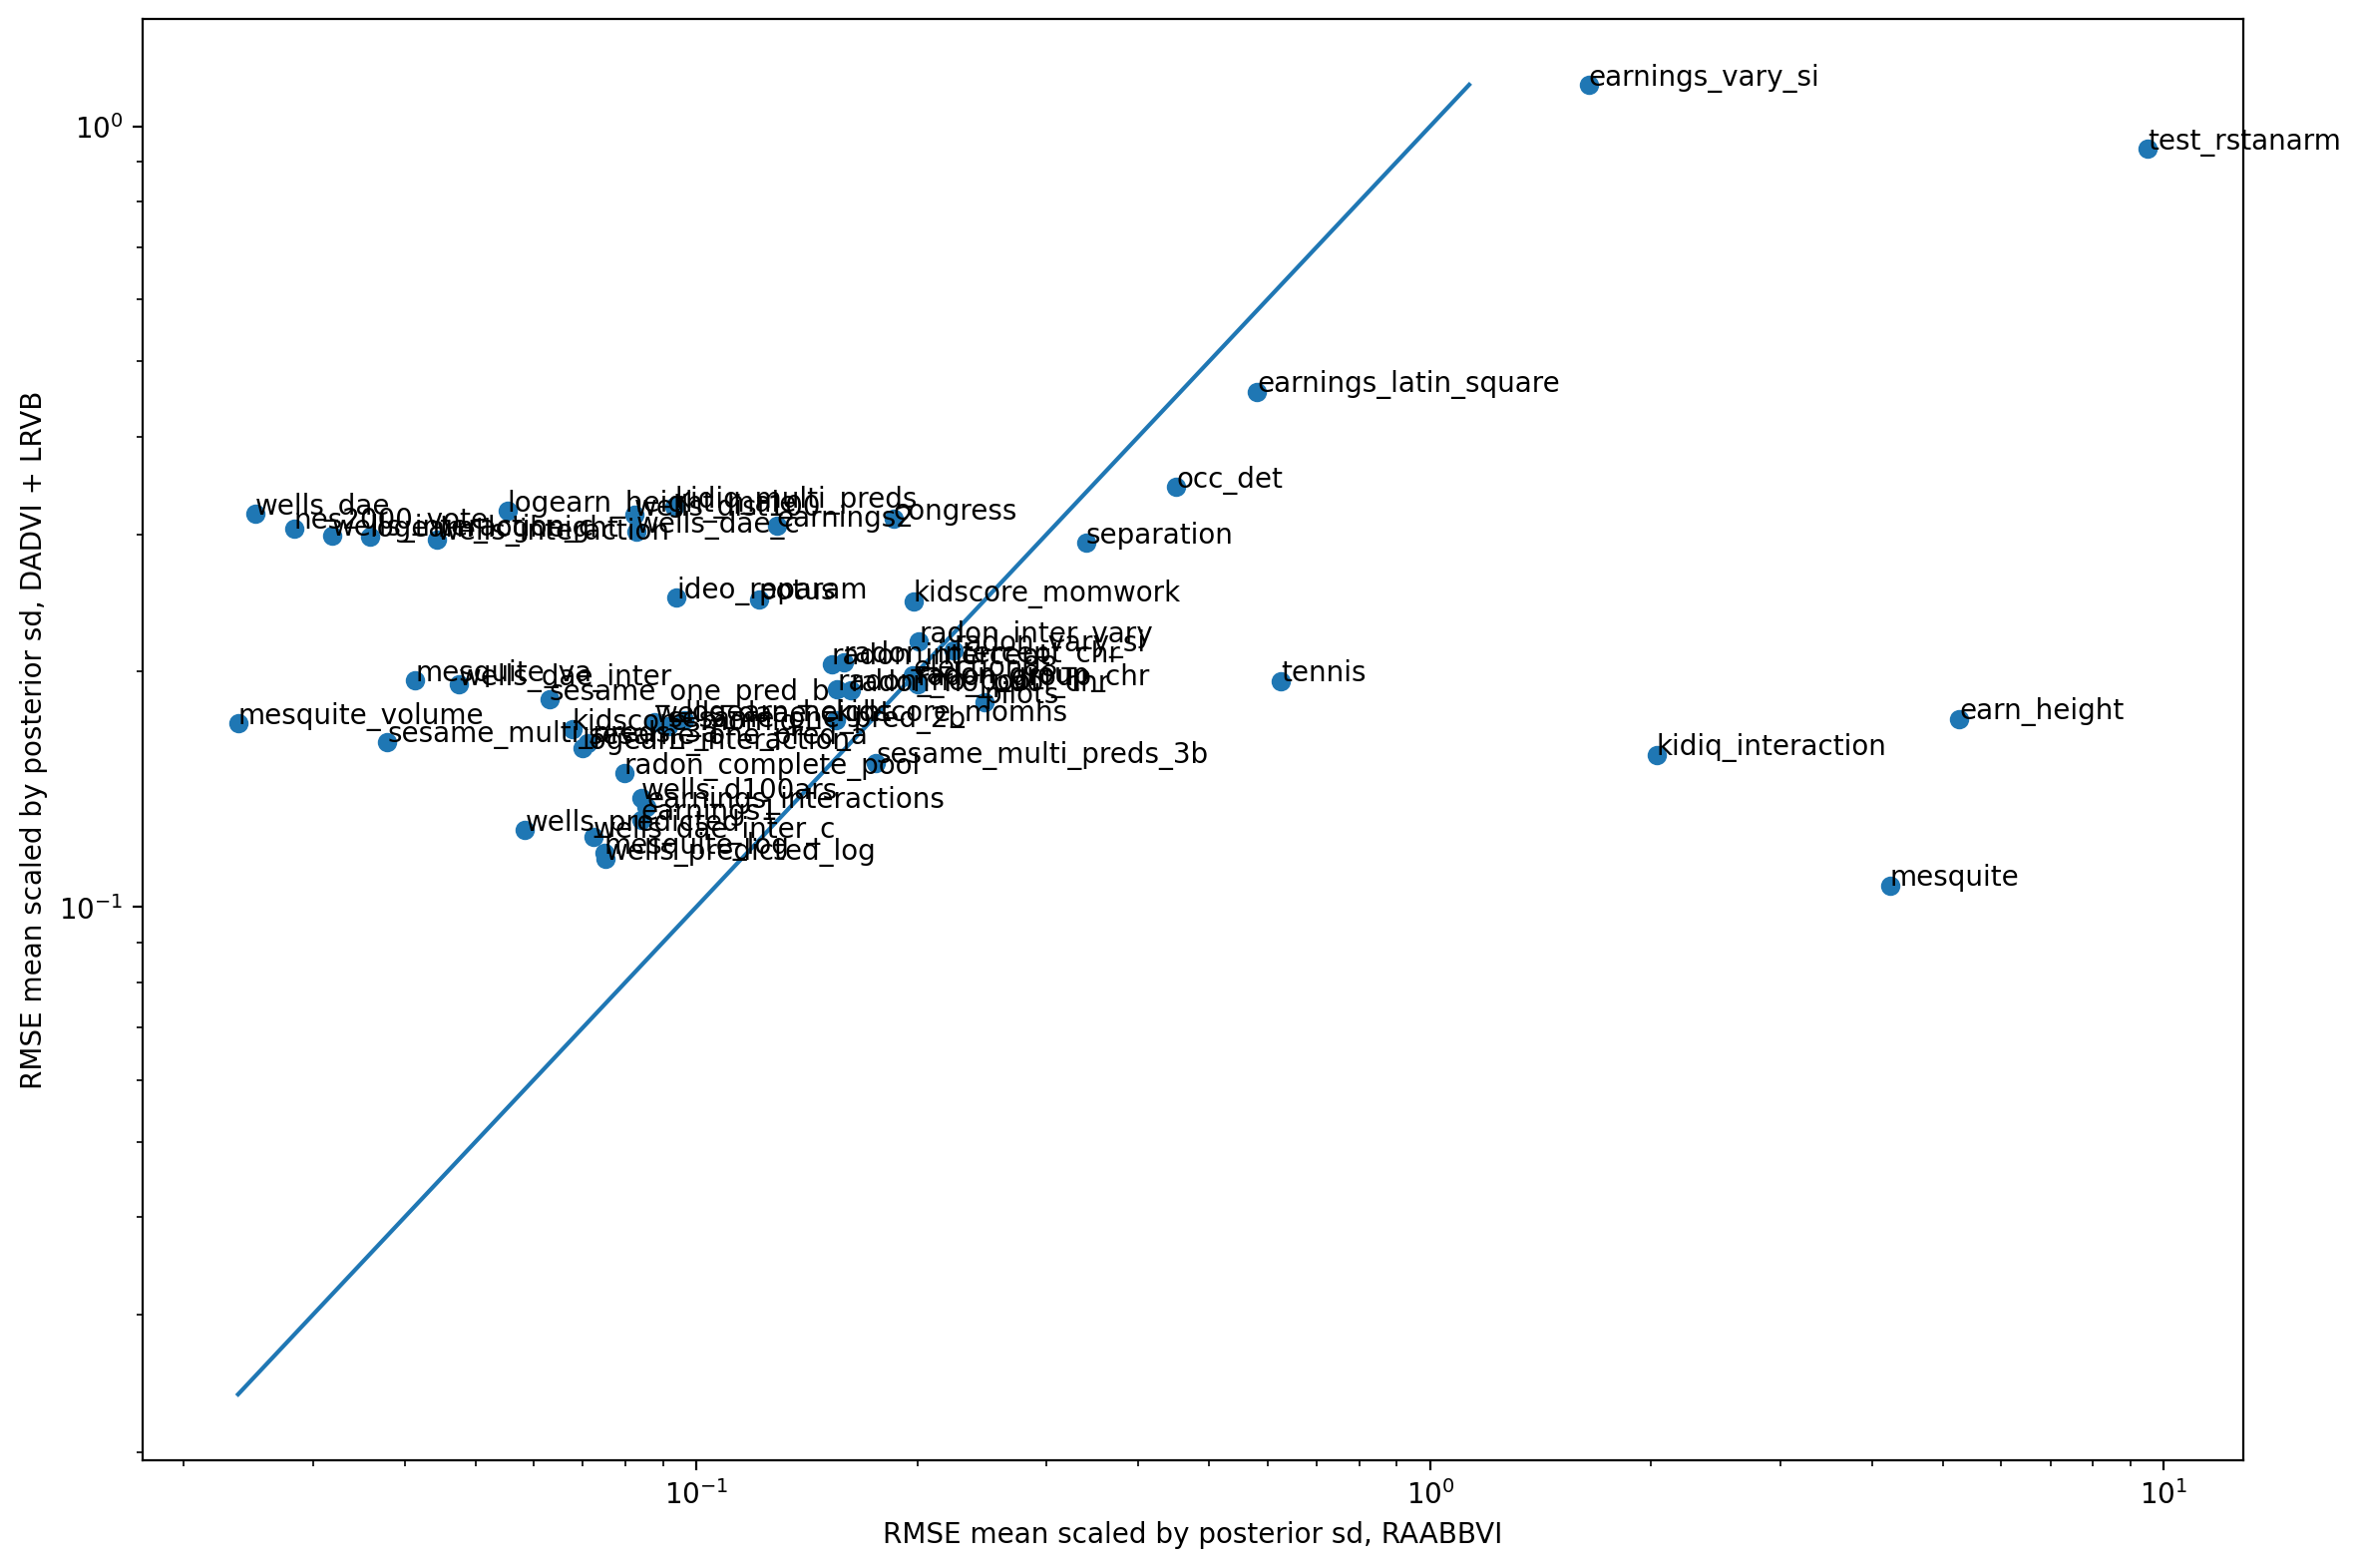

In [28]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)

xmin, xmax = [comparison['mean_rms_raabbvi'].min(), comparison['mean_rms_lrvb'].max()]
# ax.scatter(comparison['mean_rms_raabbvi'], comparison['mean_rms_lrvb'], c=comparison['converged'])
ax.scatter(comparison['mean_rms_raabbvi'], comparison['mean_rms_lrvb'])
ax.plot([xmin, xmax], [xmin, xmax])

for row in comparison.itertuples():
    ax.annotate(row.model_name, (row.mean_rms_raabbvi, row.mean_rms_lrvb))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('RMSE mean scaled by posterior sd, RAABBVI')
ax.set_ylabel('RMSE mean scaled by posterior sd, DADVI + LRVB')

f.set_size_inches(12, 8)
f.tight_layout()

# plt.savefig('./mean_comparison.png', dpi=300)


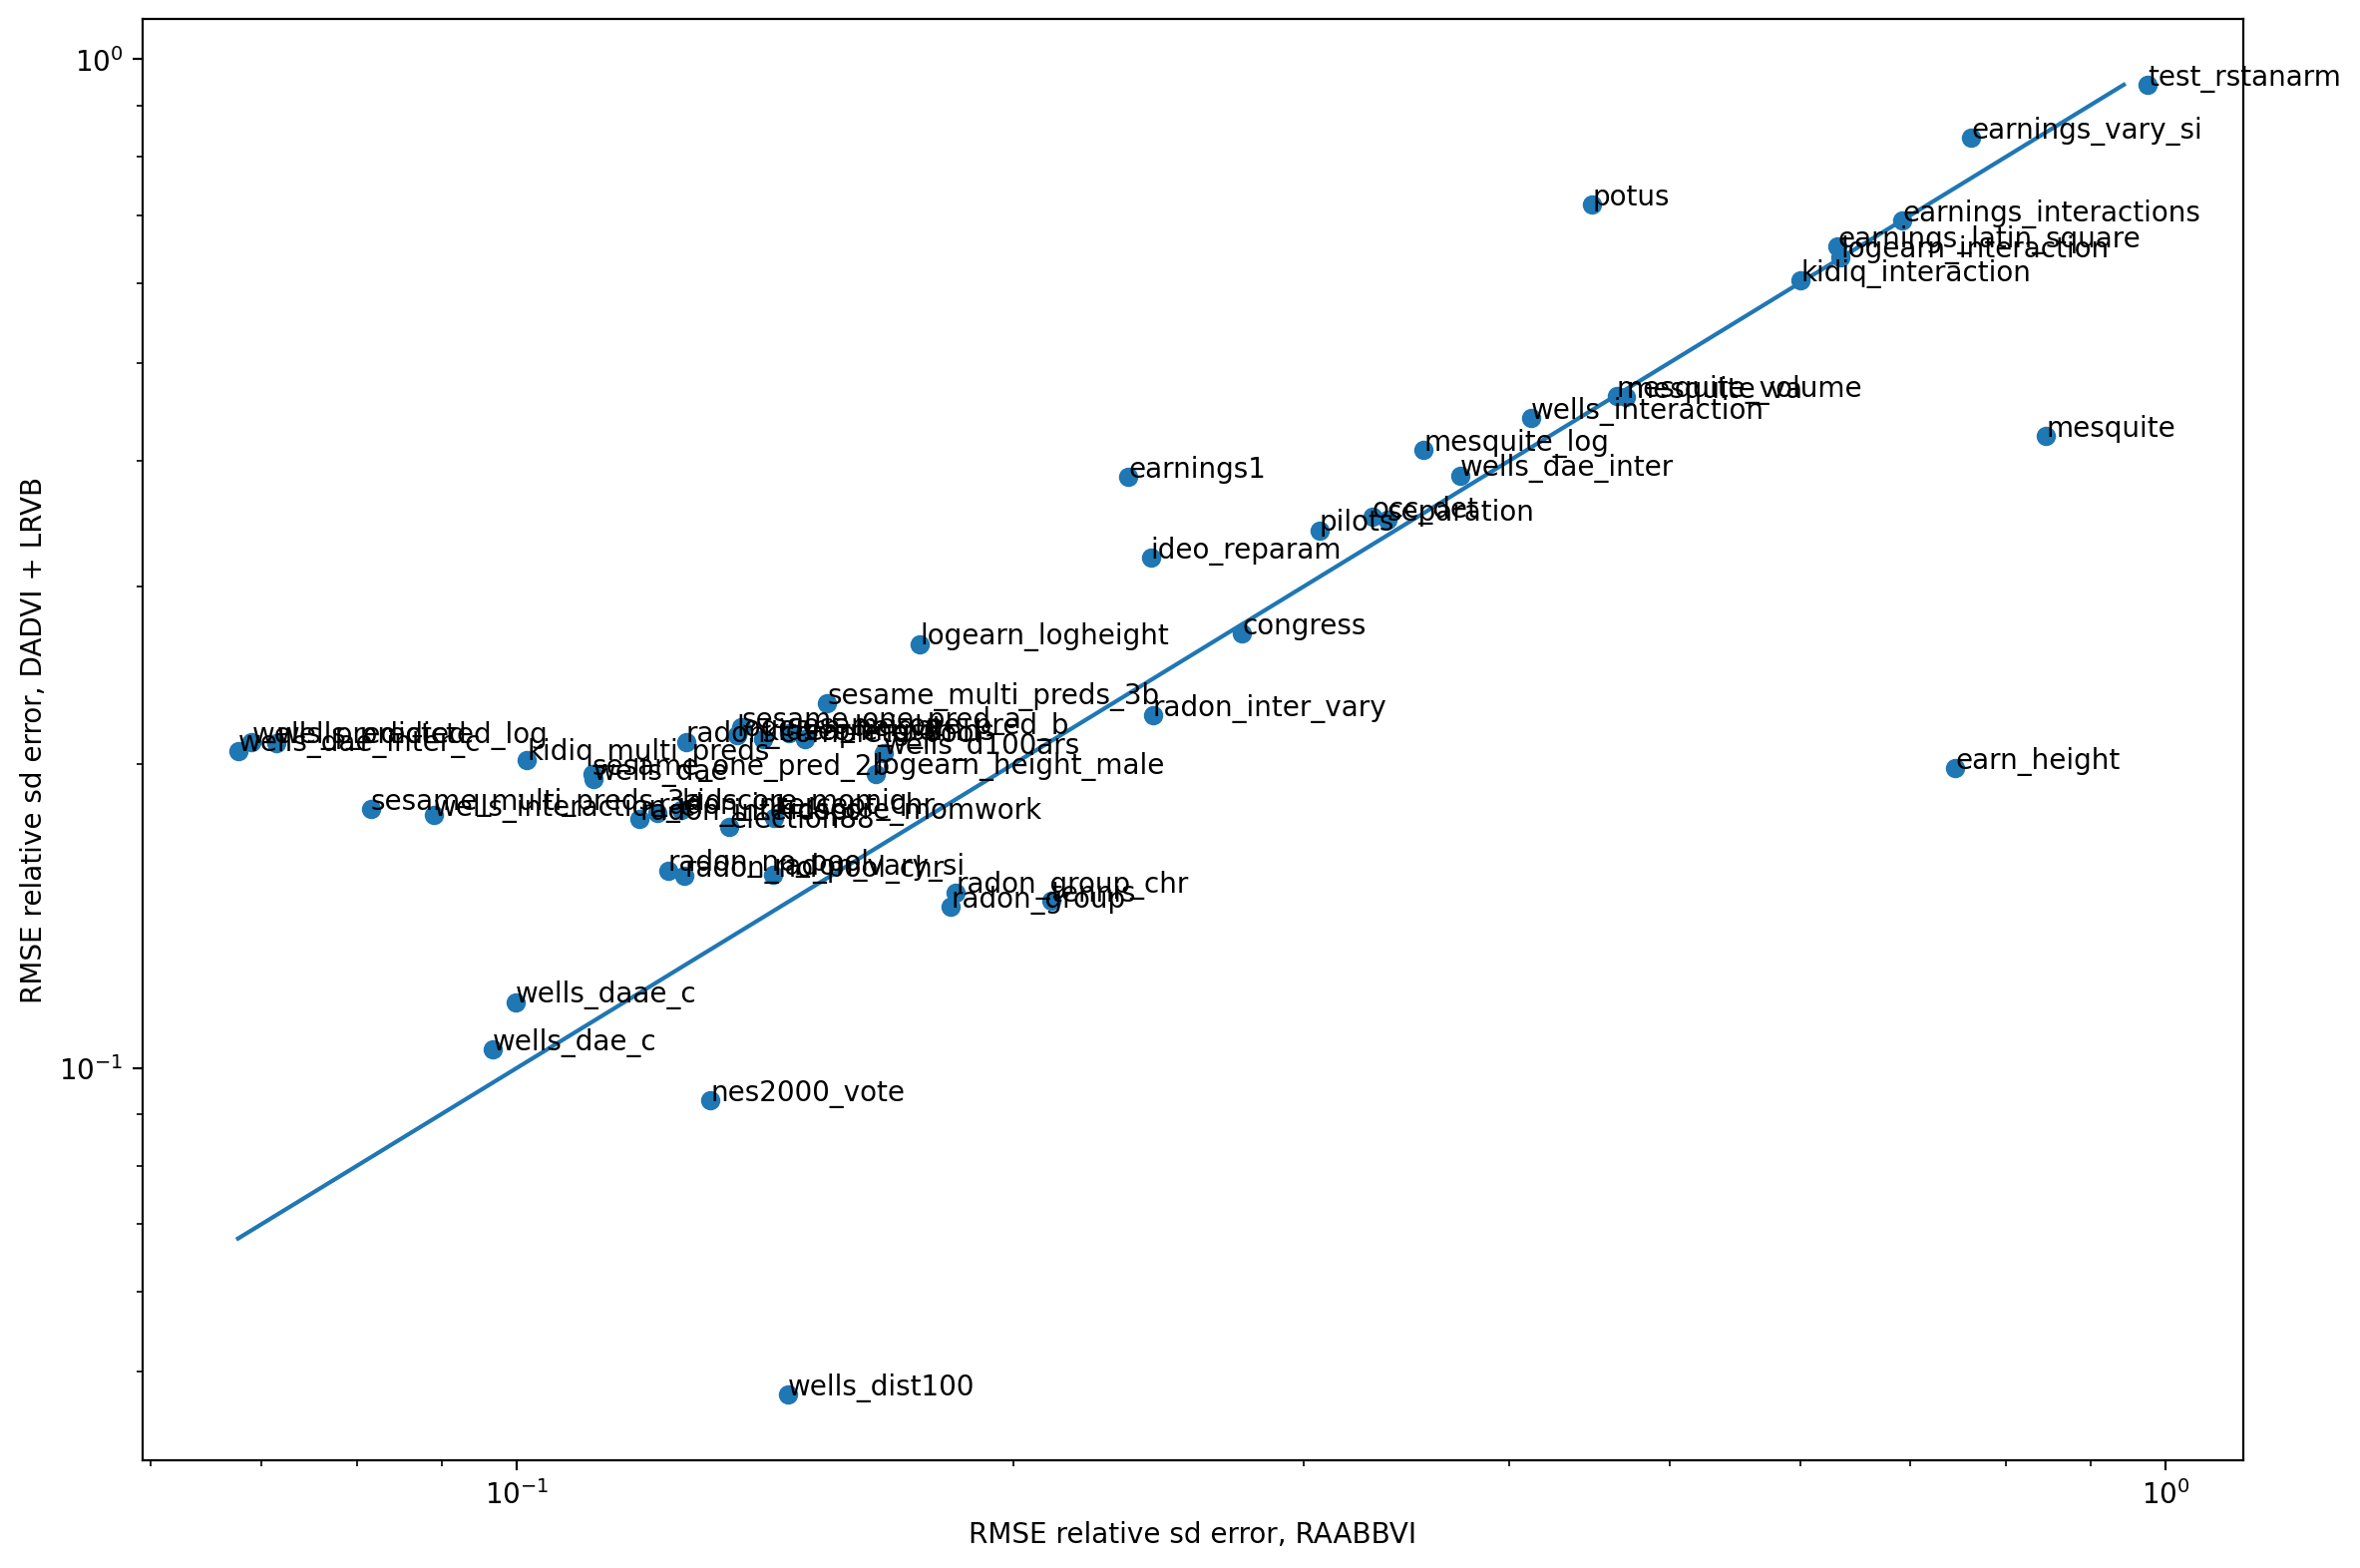

In [29]:
f, ax = plt.subplots(1, 1)

xmin, xmax = [comparison['sd_rms_raabbvi'].min(), comparison['sd_rms_lrvb'].max()]
# ax.scatter(comparison['sd_rms_raabbvi'], comparison['sd_rms_lrvb'], c=comparison['converged'])
ax.scatter(comparison['sd_rms_raabbvi'], comparison['sd_rms_lrvb'])
ax.plot([xmin, xmax], [xmin, xmax])

for row in comparison.itertuples():
    ax.annotate(row.model_name, (row.sd_rms_raabbvi, row.sd_rms_lrvb))

ax.set_xlabel('RMSE relative sd error, RAABBVI')
ax.set_ylabel('RMSE relative sd error, DADVI + LRVB')

ax.set_xscale('log')
ax.set_yscale('log')

f.set_size_inches(12, 8)
f.tight_layout()

# plt.savefig('./sd_comparison.png', dpi=300)

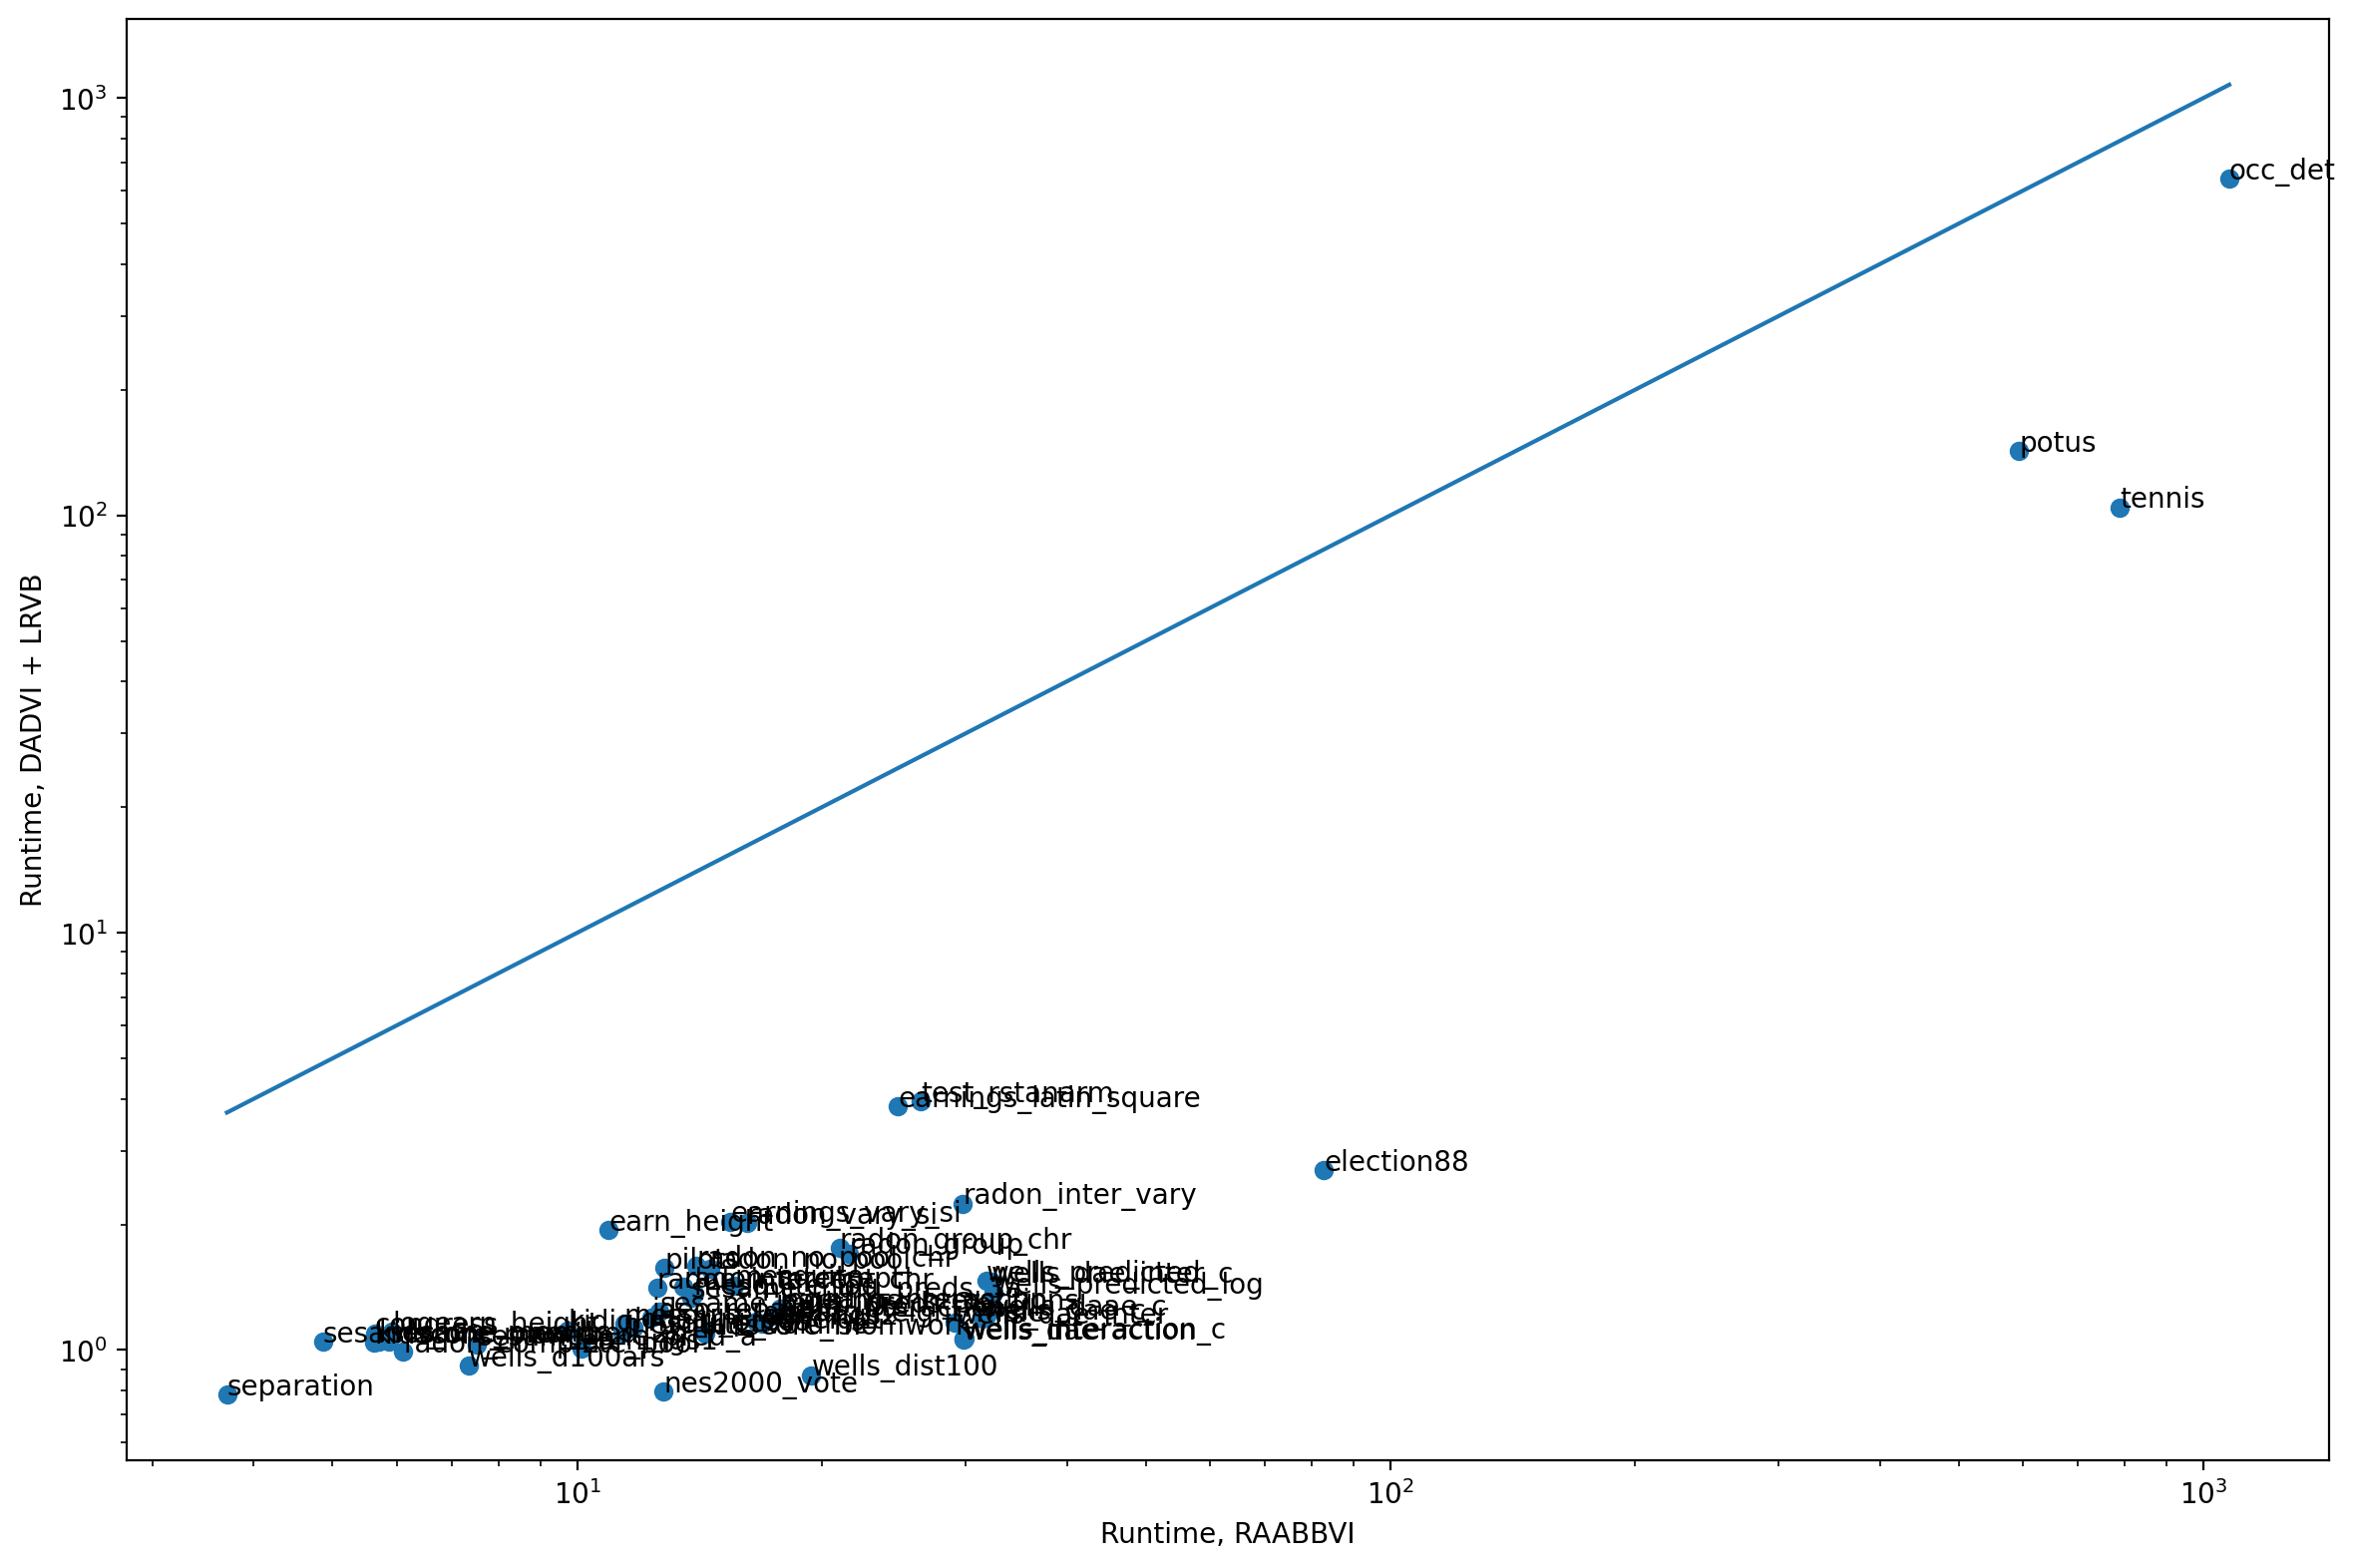

In [30]:

f, ax = plt.subplots(1, 1)

# ax.scatter(comparison['runtime_raabbvi'], comparison['runtime_lrvb'], c=comparison['converged'])
ax.scatter(comparison['runtime_raabbvi'], comparison['runtime_lrvb'])
ax.set_xscale('log')
ax.set_yscale('log')

xmin, xmax = [comparison['runtime_raabbvi'].min(), comparison['runtime_raabbvi'].max()]

for row in comparison.itertuples():
    ax.annotate(row.model_name, (row.runtime_raabbvi, row.runtime_lrvb))

ax.plot([xmin, xmax], [xmin, xmax])
ax.set_xlabel('Runtime, RAABBVI')
ax.set_ylabel('Runtime, DADVI + LRVB')

f.set_size_inches(12, 8)

f.tight_layout()

# plt.savefig('runtime_comparison.png', dpi=300)

In [31]:
comparison.head()

,draw_dict_path_lrvb,means_lrvb,sds_lrvb,model_name,info_path_lrvb,metadata_lrvb,runtime_lrvb,mean_deviations_lrvb,sd_deviations_lrvb,var_names_lrvb,...,metadata_raabbvi,runtime_raabbvi,converged,mean_deviations_raabbvi,sd_deviations_raabbvi,var_names_raabbvi,mean_deviations_flat_raabbvi,sd_deviations_flat_raabbvi,mean_rms_raabbvi,sd_rms_raabbvi
0,../blade_runs/dadvi_results/draw_dicts/radon_g...,"{'Intercept': 1.2515317210390127, 'x': [-0.666...","{'Intercept': 0.03137213718563743, 'x': [0.072...",radon_group,../blade_runs/dadvi_results/dadvi_info/radon_g...,{'opt_result': {'opt_result': {'x': [-1.547480...,1.702459,"{'Intercept': -0.16667528584520896, 'x': [0.02...","{'Intercept': -0.17278571915023538, 'x': [0.06...","[1|county, 1|county_offset, 1|county_sigma, In...",...,"{'steps': 100000, 'runtime': 21.600921630859375}",21.600922,False,"{'Intercept': -0.19277944270268577, 'x': [0.14...","{'Intercept': -0.27994643757410237, 'x': [0.05...","[1|county, 1|county_offset, 1|county_sigma, In...","[0.10777332635005446, 0.13945564330631896, -0....","[-0.2580418369989821, -0.1584649363259325, -0....",0.198941,0.183340
1,../blade_runs/dadvi_results/draw_dicts/occ_det...,"{'w_env': [[0.0934060482782328, -0.02649693837...","{'w_env': [[0.911650621609919, 1.0620146384951...",occ_det,../blade_runs/dadvi_results/dadvi_info/occ_det...,{'opt_result': {'opt_result': {'x': [13.554281...,641.103794,"{'w_env': [[-0.35623520534375297, 0.2261019063...","{'w_env': [[-0.05604796817741431, 0.0464851442...","[intercept, w_env, w_obs, w_obs_raw, w_prior_m...",...,"{'steps': 100000, 'runtime': 1076.2247185707092}",1076.224719,False,"{'w_env': [[-0.2812134582501257, 0.21291578151...","{'w_env': [[0.06530876903083187, 0.02420194797...","[intercept, w_env, w_obs, w_obs_raw, w_prior_m...","[0.4749232269604341, 0.6864714504152679, 0.346...","[-0.5369832155060851, -0.5384957306663293, -0....",0.450774,0.330227
2,../blade_runs/dadvi_results/draw_dicts/wells_i...,"{'Intercept': 0.36123505071232886, 'dist100': ...","{'Intercept': 0.04421905827981858, 'dist100': ...",wells_interaction,../blade_runs/dadvi_results/dadvi_info/wells_i...,{'opt_result': {'opt_result': {'x': [ 0.359786...,1.060802,"{'Intercept': 0.5829481305535197, 'dist100': [...","{'Intercept': 0.1576081617865387, 'dist100': [...","[Intercept, arsenic, dist100, dist100:arsenic]",...,"{'steps': 100000, 'runtime': 29.87992238998413}",29.879922,False,"{'Intercept': -0.04266402123212423, 'dist100':...","{'Intercept': 0.1070129908614286, 'dist100': [...","[Intercept, arsenic, dist100, dist100:arsenic]","[-0.04266402123212423, 0.000586945040083845, -...","[0.1070129908614286, -0.3592787604276962, -0.4...",0.044298,0.412084
3,../blade_runs/dadvi_results/draw_dicts/logearn...,"{'Intercept': 9.713650771650565, 'height': [0....","{'Intercept': 0.0343875359741509, 'height': [0...",logearn_height,../blade_runs/dadvi_results/dadvi_info/logearn...,{'opt_result': {'opt_result': {'x': [ 9.715404...,1.108099,"{'Intercept': -0.044185445228809204, 'height':...","{'Intercept': 0.34339157838983364, 'height': [...","[Intercept, height, np.log(earn)_sigma]",...,"{'steps': 46199, 'runtime': 5.917670249938965}",5.917670,True,"{'Intercept': -0.09123957772894754, 'height': ...","{'Intercept': 0.18075752575671508, 'height': [...","[Intercept, height, np.log(earn)_sigma]","[-0.09123957772894754, 0.11574914077839492, 0....","[0.18075752575671508, 0.11462476276142373, 0.0...",0.096294,0.135968
4,../blade_runs/dadvi_results/draw_dicts/wells_d...,"{'Intercept': 0.33431316389924187, 'c_dist100'...","{'Intercept': 0.03902675750194967, 'c_dist100'...",wells_dae_c,../blade_runs/dadvi_results/dadvi_info/wells_d...,{'opt_result': {'opt_result': {'x': [ 0.335257...,1.187828,"{'Intercept': -0.21185441653578962, 'c_dist100...","{'Intercept': 1.5184583464008024e-05, 'c_dist1...","[Intercept, c_arsenic, c_dist100, c_dist100:c_...",...,"{'steps': 100000, 'runtime': 31.49224543571472}",31.492245,False,"{'Intercept': -0.06843421152964252, 'c_dis